# 0. Import library and load data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import re
sns.set(style="whitegrid")

df = pd.read_csv("../data/raw/surat_uncleaned.csv")

# 1. Dataset overview

## 1.1. Basic information

In [2]:
df.head()

,property_name,areaWithType,square_feet,transaction,status,floor,furnishing,facing,description,price_per_sqft,price
0,2 BHK Apartment for Sale in Dindoli Surat,Carpet Area,644 sqft,New Property,Poss. by Oct '24,5 out of 10,Unfurnished,West,"Luxury project with basement parking, Solar ro...","₹2,891 per sqft",₹33.8 Lac
1,2 BHK Apartment for Sale in Althan Surat,Super Area,1278 sqft,New Property,Poss. by Jan '26,6 out of 14,Unfurnished,South -West,2 And 3 BHK Luxurious Flat for Sell In New Alt...,"₹3,551 per sqft",₹45.4 Lac
2,2 BHK Apartment for Sale in Pal Gam Surat,Super Area,1173 sqft,Resale,Ready to Move,5 out of 13,Semi-Furnished,East,This affordable 2 BHK flat is situated along a...,"₹3,800 per sqft",₹44.6 Lac
3,2 BHK Apartment for Sale in Jahangirabad Surat,Carpet Area,700 sqft,New Property,Ready to Move,6 out of 14,Unfurnished,East,2 BHK Flat For sell IN Jahangirabad Prime Loca...,"₹3,966 per sqft",₹47 Lac
4,"2 BHK Apartment for Sale in Orchid Fantasia, P...",Super Area,1250 sqft,Orchid Fantasia,New Property,Unfurnished,2,2,"Multistorey Apartment for Sale in Palanpur, Su...","₹3,600 per sqft",₹45 Lac


In [3]:
df.info()
print("Approx. size (MB):", df.memory_usage(deep=True).sum()/(1024**2))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4525 entries, 0 to 4524
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   property_name   4525 non-null   object
 1   areaWithType    4525 non-null   object
 2   square_feet     4525 non-null   object
 3   transaction     4421 non-null   object
 4   status          4524 non-null   object
 5   floor           4480 non-null   object
 6   furnishing      4185 non-null   object
 7   facing          3936 non-null   object
 8   description     3154 non-null   object
 9   price_per_sqft  4157 non-null   object
 10  price           4525 non-null   object
dtypes: object(11)
memory usage: 389.0+ KB
Approx. size (MB): 3.714496612548828


In [4]:
df.sample(5)

,property_name,areaWithType,square_feet,transaction,status,floor,furnishing,facing,description,price_per_sqft,price
2569,"3 BHK Apartment for Sale in Sun Sarvam, Vesu S...",Super Area,1993 sqft,Unfurnished,Poss. by Aug '24,New Property,Sun Sarvam,3,"Multistorey Apartment for Sale in Vesu, Surat....","₹4,751 per sqft",₹94.7 Lac
4190,4 BHK Apartment for Sale in Shyam Shree Niketa...,Super Area,2870 sqft,Resale,Ready to Move,4 out of 10,Furnished,East,4 BHK Flat For Sale2870 Sq.Ft AreaFully Furnis...,"₹8,711 per sqft",₹2.50 Cr
4311,6 BHK Villa for Sale in Vesu Surat,Carpet Area,5000 sqft,Unfurnished,Ready to Move,New Property,5,3,4 car parking in bungalow. bungalow elevation...,NaN,₹4.51 Cr
198,2 BHK Apartment for Sale in Adajan Surat,Super Area,960 sqft,Semi-Furnished,3 out of 7,Resale,2,NaN,NaN,"₹4,167 per sqft",₹40 Lac
34,2 BHK Apartment for Sale in Godadara Surat,Carpet Area,725 sqft,New Property,Poss. by Jan '25,7 out of 14,Unfurnished,South -West,2 and 3 bhk luxurious flats at prime locations.,"₹3,500 per sqft",₹46.2 Lac


- **Number of rows:** The dataset contains **4,525 rows** (index ranges from **0** to **4,524**).
- **Number of columns:** The dataset contains **11 columns**.

- **What does each row represent?**  
  Each row corresponds to **one real-estate property listing** in Surat. This is supported by the `property_name` field (e.g., “2 BHK Apartment for Sale in … Surat”), while the remaining columns describe the listing’s attributes such as area, transaction/status, floor, furnishing/facing, a short description, and pricing information.

- **Overall dataset size:**  
  The DataFrame’s memory footprint is approximately **4.2 MB**.

- **Quick structural note (from `df.info()`):**  
  All **11 columns are stored as `object` type**, indicating that many values are currently represented as text (e.g., `"644 sqft"`, `"₹2,891 per sqft"`, `"₹33.8 Lac"`). This is expected for an *uncleaned* dataset and suggests that type conversion and text parsing will be required during preprocessing.

## 1.2. Data Integrity

In [5]:
dup_full = df.duplicated().sum()
empty_rows = df.isna().all(axis=1).sum()

print("Duplicated rows:", dup_full)
print("Fully empty rows:", empty_rows)

Duplicated rows: 109
Fully empty rows: 0


These duplicates should **be removed** because each row represents a single property listing. Exact duplicates most likely come from repeated scraping/entries and would **inflate the frequency** of certain listings, biasing distribution-based analyses (e.g., price, area) and potentially harming model training by over-representing repeated records.

## 1.3. Column Inventory 

In [6]:
def column_inventory(df, top_k=5):
    inv = pd.DataFrame({
        "column": df.columns,
        "dtype": df.dtypes.astype(str).values,
        "missing_count": df.isna().sum().values,
        "missing_pct": (df.isna().mean() * 100).round(2).values,
        "n_unique": df.nunique(dropna=True).values,
        "example": [
            df[c].dropna().iloc[0] if df[c].notna().any() else np.nan
            for c in df.columns
        ],
    })

    # Add top categories for object columns
    top_values = {}
    for c in df.columns:
        if df[c].dtype == "object":
            vc = df[c].astype(str).str.strip().replace("nan", np.nan).value_counts(dropna=True).head(top_k)
            top_values[c] = ", ".join([f"{idx} ({val})" for idx, val in vc.items()])
        else:
            top_values[c] = ""
    inv["top_values"] = inv["column"].map(top_values)

    return inv.sort_values("missing_pct", ascending=False)

inventory = column_inventory(df, top_k=5)
inventory

,column,dtype,missing_count,missing_pct,n_unique,example,top_values
8,description,object,1371,30.30,2588,"Luxury project with basement parking, Solar ro...",Multistorey apartment is available for sale. I...
7,facing,object,589,13.02,176,West,"East (1487), South -West (354), 2 (329), 1 (25..."
9,price_per_sqft,object,368,8.13,2134,"₹2,891 per sqft","₹5,000 per sqft (64), ₹6,000 per sqft (64), ₹4..."
6,furnishing,object,340,7.51,78,Unfurnished,"Unfurnished (2322), Semi-Furnished (491), Furn..."
3,transaction,object,104,2.30,38,New Property,"Resale (2197), New Property (1486), Unfurnishe..."
5,floor,object,45,0.99,222,5 out of 10,"Resale (431), New Property (267), 5 out of 13 ..."
4,status,object,1,0.02,138,Poss. by Oct '24,"Ready to Move (3078), Poss. by Dec '24 (155), ..."
2,square_feet,object,0,0.00,1399,644 sqft,"1000 sqft (77), 800 sqft (64), 1100 sqft (62),..."
1,areaWithType,object,0,0.00,6,Carpet Area,"Super Area (2599), Carpet Area (1671), Plot Ar..."
0,property_name,object,0,0.00,1992,2 BHK Apartment for Sale in Dindoli Surat,"3 BHK Apartment for Sale in Vesu Surat (93), 3..."


In [7]:
# 1) High-missing columns (tune threshold as needed)
high_missing = inventory[inventory["missing_pct"] > 30]["column"].tolist()

# 2) Near-constant columns (not expected here, but good practice)
near_constant = inventory[inventory["n_unique"] <= 1]["column"].tolist()

print("High-missing (>30%) candidates:", high_missing)
print("Near-constant candidates:", near_constant)

High-missing (>30%) candidates: ['description']
Near-constant candidates: []


### Meaning / definition of each column
The dataset contains 11 columns describing one property listing in Surat:

- **property_name**: Listing headline (often includes BHK + property type + locality).
- **areaWithType**: Declared area type (e.g., *Super Area*, *Carpet Area*, *Plot Area*).
- **square_feet**: Property size stored as text with units (e.g., “1000 sqft”); should be parsed to numeric `area_sqft`.
- **transaction**: Transaction type (expected: *New Property* / *Resale*).
- **status**: Availability/possession status (e.g., *Ready to Move*, *Poss. by Oct '24*).
- **floor**: Floor information (e.g., “5 out of 10”); should be parsed to `floor_num` and `total_floors`.
- **furnishing**: Furnishing level (e.g., *Unfurnished*, *Semi-Furnished*, *Furnished*).
- **facing**: Direction the property faces (e.g., *East*, *West*, *South-West*).
- **description**: Free-text description of features/amenities.
- **price_per_sqft**: Price per sqft in text format (e.g., “₹2,891 per sqft”); should be parsed to numeric.
- **price**: Listing price in text format (e.g., “₹33.8 Lac”, “₹1.29 Cr”, “Call for Price”); main target after conversion.

### Column relevance for potential analysis
Based on missingness and uniqueness from the inventory table:

- **Core variables for pricing analysis / modeling**
  - `price` (target; note “Call for Price” is a placeholder and should be treated as missing for numeric analysis)
  - `square_feet` (key driver after parsing to numeric)
  - `transaction`, `status`, `furnishing`, `facing`, `floor`, `areaWithType` (important categorical/structured factors)

- **Helpful but requires feature extraction**
  - `property_name` (high-cardinality text: 1,992 unique values). Useful to extract structured features such as `bhk`, `property_type`, and locality keywords.

- **Optional / scope-dependent**
  - `description` (text-heavy and **30.30% missing**; 2,588 unique). Useful only if we plan to do basic NLP/keyword features; otherwise optional.

### Data quality notes from the inventory (important findings)
- **Missingness**
  - `description` has the highest missing rate (**30.30%**, 1,371 missing), making it the primary “high-missing” column.
  - Moderate missing appears in `facing` (**13.02%**) and `price_per_sqft` (**8.13%**) and `furnishing` (**7.51%**).
  - `areaWithType`, `square_feet`, `price`, and `property_name` have **0% missing**.

- **High cardinality / string-numeric issues**
  - `price_per_sqft` has **2,134 unique** values and is stored as text, indicating it behaves like a numeric column but requires parsing and cleaning.
  - `square_feet` has **1,399 unique** values, also text-based numeric with units.

- **Potential column contamination (red flag)**
  - The most frequent values suggest some columns contain unexpected categories:
    - `transaction` includes values that look like furnishing categories (e.g., “Unfurnished”).
    - `floor` shows top values such as “Resale” and “New Property”, which should belong to `transaction`.
    - `facing` contains numeric-like categories (e.g., “2”, “1”), which are not valid facing directions.
  - This indicates **inconsistent entries and likely misaligned/shifted values** in a subset of rows, which must be handled during preprocessing (rule-based validation + set invalid values to NaN/Other).

### Columns that could be dropped
- **`description`** is the main drop candidate:
  - Highest missing rate (**30.30%**) and free-text complexity.
  - We are not doing text/NLP features, so dropping it simplifies preprocessing and reduces noise for ML.

- **`property_name`** should not be dropped immediately:
  - Recommended approach: **extract structured features** (e.g., BHK/property type/locality) first, then optionally drop the raw text column for modeling.

- **`price_per_sqft`** should be used carefully:
  - Useful for EDA and consistency checks.
  - For a price prediction model, it may introduce **data leakage** if it is derived from `price` and `square_feet`. We will consider excluding it from the ML feature set when predicting `price`.

## 1.4. Data Types

In [8]:
target_mapping = {
    'property_name':  'String (Text)',
    'areaWithType':   'Categorical',
    'square_feet':    'Numeric (Float)',
    'transaction':    'Categorical',
    'status':         'Categorical',
    'floor':          'Numeric',
    'furnishing':     'Categorical',
    'facing':         'Categorical',
    'description':    'String (Text)',
    'price_per_sqft': 'Numeric (Float)',
    'price':          'Numeric (Float)'
}

type_analysis_data = []

for col in df.columns:
    current_dtype = df[col].dtype
    example_val = df[col].dropna().iloc[0] if not df[col].dropna().empty else "NaN"
    target_dtype = target_mapping.get(col, "Unknown")
    
    needs_conversion = (str(current_dtype) == 'object') and \
                       (target_dtype != 'String (Text)')
    
    reason = ""
    if needs_conversion:
        if 'Numeric' in target_dtype:
            reason = "Contains units/symbols (₹, sqft, commas, text)"
        elif 'Categorical' in target_dtype:
            reason = "High repetition, better memory usage as category"

    type_analysis_data.append({
        'Column': col,
        'Current Dtype': str(current_dtype),
        'Example Value': example_val,
        'Target Dtype': target_dtype,
        'Needs Conversion': needs_conversion,
        'Reason': reason
    })

type_analysis_df = pd.DataFrame(type_analysis_data)
display(type_analysis_df)

,Column,Current Dtype,Example Value,Target Dtype,Needs Conversion,Reason
0,property_name,object,2 BHK Apartment for Sale in Dindoli Surat,String (Text),False,
1,areaWithType,object,Carpet Area,Categorical,True,"High repetition, better memory usage as category"
2,square_feet,object,644 sqft,Numeric (Float),True,"Contains units/symbols (₹, sqft, commas, text)"
3,transaction,object,New Property,Categorical,True,"High repetition, better memory usage as category"
4,status,object,Poss. by Oct '24,Categorical,True,"High repetition, better memory usage as category"
5,floor,object,5 out of 10,Numeric,True,"Contains units/symbols (₹, sqft, commas, text)"
6,furnishing,object,Unfurnished,Categorical,True,"High repetition, better memory usage as category"
7,facing,object,West,Categorical,True,"High repetition, better memory usage as category"
8,description,object,"Luxury project with basement parking, Solar ro...",String (Text),False,
9,price_per_sqft,object,"₹2,891 per sqft",Numeric (Float),True,"Contains units/symbols (₹, sqft, commas, text)"


### Current Data Type Status
Based on our detailed type analysis, **all 11 columns** in the dataset are currently stored as `object` (string). While this is common for raw web-scraped data, it is inappropriate for data analysis because mathematical operations (e.g., calculating average price) and statistical summaries cannot be performed on text strings.

### Inappropriate Data Types & Conversion Plan
We have identified that **9 out of 11 columns** require type conversion. The table below details the specific issues found in the raw data and our target data types:

| Column | Current Dtype | Example Value | Target Dtype | Issue / Reason for Conversion |
| :--- | :--- | :--- | :--- | :--- |
| **square_feet** | Object | `644 sqft` | **Float** | Contains non-numeric units ("sqft") preventing numerical calculation. |
| **price** | Object | `₹33.8 Lac` | **Float** | Contains currency symbols (`₹`), units (`Lac`, `Cr`), and text placeholders like "Call for Price". |
| **price_per_sqft**| Object | `₹2,891 per sqft`| **Float** | Contains currency symbols (`₹`), text (`per sqft`), and commas. |
| **floor** | Object | `5 out of 10` | **Numeric (Split)**| Contains compound information (Current Floor + Total Floors) as a string. Needs parsing. |
| **transaction** | Object | `New Property` | **Category** | High repetition of values. Converting to Category reduces memory usage and improves semantics. |
| **status** | Object | `Poss. by Oct '24`| **Category** | Represents a finite set of project states. |
| **furnishing** | Object | `Unfurnished` | **Category** | Represents ordinal/nominal categories suitable for encoding. |
| **facing** | Object | `West` | **Category** | Represents nominal directional categories. |
| **areaWithType** | Object | `Carpet Area` | **Category** | Represents nominal area definitions. |

*Note: `property_name` and `description` will remain as **String (Text)** objects as they are unstructured text fields.*

### Conversion Strategy
To prepare the dataset for the **Data Analysis** phase, we will implement the following preprocessing steps:

1.  **Numerical Parsing:**
    * **Price Cleaning:** We must handle Indian numbering units where `Lac` = 100,000 and `Cr` (Crore) = 10,000,000 to convert strings like "₹33.8 Lac" into actual integers (e.g., 3,380,000). Rows with "Call for Price" will be treated as missing values.
    * **Unit Removal:** Remove **"sqft"**, **"₹"**, and commas from `square_feet` and `price_per_sqft`.

2.  **Structural Parsing:**
    * The `floor` column will be split into two new numerical features: `floor_level` (numerator) and `total_floors` (denominator).

3.  **Categorical Casting:**
    * Columns with low cardinality (`transaction`, `status`, `furnishing`, `facing`, `areaWithType`) will be standardized and converted to the `category` data type to optimize performance and enable categorical plotting.

# 2. Numerical Columns Analysis 

## 2.1 Convert numerical column

In [9]:
tmp = df.copy()
def parse_area_sqft(s):
    if pd.isna(s): 
        return np.nan
    t = str(s).strip().lower().replace(",", "")
    m = re.search(r"(\d+(\.\d+)?)", t)
    if not m:
        return np.nan
    num = float(m.group(1))
    # unit detection
    if "sqft" in t:
        return num
    if "sqyd" in t or "sqyrd" in t:
        return num * 9
    if "sqm" in t or "sq.m" in t:
        return num * 10.7639
    if "acre" in t:
        return num * 43560
    if "rood" in t:
        return num * 10890
    if "ground" in t:
        return num * 2400
    return np.nan

def parse_ppsqft(s):
    if pd.isna(s): 
        return np.nan
    t = str(s).lower().replace("₹", "").replace(",", "")
    m = re.search(r"(\d+(\.\d+)?)", t)
    return float(m.group(1)) if m else np.nan

def parse_price_lakh(s):
    if pd.isna(s): 
        return np.nan
    t = str(s).strip().lower()
    if t == "call for price":
        return np.nan
    t = t.replace("₹", "").replace(",", "")
    m = re.search(r"(\d+(\.\d+)?)", t)
    if not m:
        return np.nan
    num = float(m.group(1))
    # unit conversion
    if "cr" in t:        # crore
        return num * 100
    if "lac" in t or "lakh" in t:
        return num
    # unknown → NaN
    return np.nan

def parse_bhk_from_name(s):
    if pd.isna(s):
        return np.nan
    m = re.search(r"(\d+)\s*bhk", str(s), flags=re.IGNORECASE)
    return float(m.group(1)) if m else np.nan

def parse_floor(s):
    if pd.isna(s):
        return (np.nan, np.nan)
    t = str(s).strip().lower()

    # quick filter: only attempt parsing if pattern contains "out of"
    if "out of" not in t:
        return (np.nan, np.nan)

    # handle "ground out of X"
    if t.startswith("ground"):
        m = re.search(r"ground\s*out\s*of\s*(\d+)", t)
        if m:
            return (0.0, float(m.group(1)))
        return (np.nan, np.nan)

    # normal case: "5 out of 13"
    m = re.search(r"(\d+)\s*out\s*of\s*(\d+)", t)
    if m:
        return (float(m.group(1)), float(m.group(2)))

    return (np.nan, np.nan)

tmp["area_sqft"]  = tmp["square_feet"].apply(parse_area_sqft)
tmp["ppsqft"]     = tmp["price_per_sqft"].apply(parse_ppsqft)
tmp["price_lakh"] = tmp["price"].apply(parse_price_lakh)
tmp["bhk"]        = tmp["property_name"].apply(parse_bhk_from_name)
tmp[["floor_num", "total_floors"]] = tmp["floor"].apply(parse_floor).apply(pd.Series)
tmp["floor_ratio"] = tmp["floor_num"] / tmp["total_floors"]

tmp[["area_sqft","ppsqft","price_lakh","bhk","floor_ratio"]].head()

,area_sqft,ppsqft,price_lakh,bhk,floor_ratio
0,644.0,2891.0,33.8,2.0,0.500000
1,1278.0,3551.0,45.4,2.0,0.428571
2,1173.0,3800.0,44.6,2.0,0.384615
3,700.0,3966.0,47.0,2.0,0.428571
4,1250.0,3600.0,45.0,2.0,NaN


In [10]:
num_cols = ["area_sqft", "ppsqft", "price_lakh", "bhk", "floor_num", "total_floors", "floor_ratio"]

summary = pd.DataFrame({
    "missing_count": tmp[num_cols].isna().sum(),
    "missing_pct": (tmp[num_cols].isna().mean()*100).round(2),
    "mean": tmp[num_cols].mean(numeric_only=True),
    "median": tmp[num_cols].median(numeric_only=True),
    "std": tmp[num_cols].std(numeric_only=True),
    "min": tmp[num_cols].min(numeric_only=True),
    "max": tmp[num_cols].max(numeric_only=True),
}).reset_index().rename(columns={"index":"column"})

summary

,column,missing_count,missing_pct,mean,median,std,min,max
0,area_sqft,6,0.13,6782.268609,1283.0,162541.774733,1.0,8400000.0
1,ppsqft,368,8.13,9478.185230,4700.0,194058.626189,1.0,12500000.0
2,price_lakh,173,3.82,132.082376,71.0,856.328971,1.0,53444.0
3,bhk,636,14.06,2.840833,3.0,1.092492,1.0,10.0
4,floor_num,908,20.07,4.868399,5.0,3.385834,0.0,20.0
5,total_floors,908,20.07,9.582803,12.0,4.736691,1.0,30.0
6,floor_ratio,908,20.07,0.495615,0.5,0.286118,0.0,1.0


In [11]:
cols_to_check = ["area_sqft", "ppsqft", "price_lakh", "bhk"]
def show_extremes(df_tmp, col, n=8):
    s = df_tmp[col].dropna()
    if s.empty:
        print(f"{col}: no valid numeric values")
        return
    
    idx_min = s.nsmallest(n).index
    idx_max = s.nlargest(n).index
    
    display(df_tmp.loc[idx_min, ["property_name","square_feet","price_per_sqft","price","floor", col]])
    display(df_tmp.loc[idx_max, ["property_name","square_feet","price_per_sqft","price","floor", col]])

for c in cols_to_check:
    show_extremes(tmp, c, n=2)

,property_name,square_feet,price_per_sqft,price,floor,area_sqft
1143,1 BHK Apartment for Sale in Katargam Surat,1 sqft,NaN,Call for Price,1 out of 3,1.0
178,1 BHK Apartment for Sale in suman ashish Surat,3 sqft,"₹3,429 per sqft",₹12 Lac,2 out of 7,3.0


,property_name,square_feet,price_per_sqft,price,floor,area_sqft
1040,Plot/Land for Sale in Kim Surat,8400000 sqft,NaN,Call for Price,NaN,8.400000e+06
3826,2 BHK House for Sale in Adajan Surat,"390,045 sqm",₹349 per sqft,₹146.33 Cr,1 out of 1,4.198405e+06


,property_name,square_feet,price_per_sqft,price,floor,ppsqft
487,Land for Sale in Udhog nagar navagam Surat,95000 sqft,₹1 per sqft,₹1 Lac,NaN,1.0
920,2 BHK House for Sale in Majura Gate Surat,90 acre,₹1 per sqft,₹50 Lac,Resale,1.0


,property_name,square_feet,price_per_sqft,price,floor,ppsqft
3718,Industrial Land for Sale in Kim Surat,10 sqft,"₹1,25,00,000 per sqft",₹12.50 Cr,NaN,12500000.0
1986,2 BHK House for Sale in Meera Nagar Surat,16 sqft,"₹2,00,000 per sqft",₹1 Cr,Resale,200000.0


,property_name,square_feet,price_per_sqft,price,floor,price_lakh
487,Land for Sale in Udhog nagar navagam Surat,95000 sqft,₹1 per sqft,₹1 Lac,NaN,1.0
853,Office Space for Sale in Aakash Business Cen...,1100 sqft,₹45 per sqft,₹1 Lac,4 out of 4,1.0


,property_name,square_feet,price_per_sqft,price,floor,price_lakh
3731,1 BHK Apartment for Sale in 395004 Surat,27646 sqft,"₹9,852 per sqft",₹534.44 Cr,3 out of 7,53444.0
3826,2 BHK House for Sale in Adajan Surat,"390,045 sqm",₹349 per sqft,₹146.33 Cr,1 out of 1,14633.0


,property_name,square_feet,price_per_sqft,price,floor,bhk
11,1 BHK House for Sale in Kim Surat,480 sqft,"₹2,315 per sqft",₹12.5 Lac,1 out of 1,1.0
19,1 BHK Apartment for Sale in Ramnagar Surat,731 sqft,"₹2,736 per sqft",₹20 Lac,2 out of 5,1.0


,property_name,square_feet,price_per_sqft,price,floor,bhk
1625,10 BHK House for Sale in Bombay Market Surat,3000 sqft,"₹3,333 per sqft",₹1 Cr,Ground out of 3,10.0
3049,10 BHK House for Sale in Bombay Market Surat,3000 sqft,"₹3,333 per sqft",₹1 Cr,Ground out of 3,10.0


**Minimum Values (Indicate Errors):**

- Observation: The minimum values for `area_sqft`, `price_lakh`, and `ppsqft` are all 1.0.

- Evidence:

  - Row 1143: A "1 BHK Apartment" lists area_sqft as 1 sqft and Price as "Call for Price". The value 1 is clearly a placeholder for missing data.

  - Row 487: A "Land for Sale" entry lists price_lakh as 1.0 (1 Lac) and ppsqft as 1.0, while the area is 95,000 sqft. This is an unrealistic price, likely used as a placeholder.

- `floor_num` (Min = 0.0) and `total_floors` (Min = 1.0): Reasonable, indicating the Ground Floor and a single-story independent houses or villas.

**Maximum Values (Mixed: Outliers vs. Potential Errors):**

- `bkh` (Max: 10): Reasonable.

  - Evidence: Rows 1625 & 3049 show "10 BHK House" with 3000 sqft priced at ₹1 Cr. This is a plausible configuration (e.g., a multi-story independent house or hostel).

- `price_lakhs` (Max: 53,444 Lakh ~ 534 Cr):

  - Evidence: Row 3731 lists a "1 BHK Apartment" with a price of ₹534.44 Cr (53,444 Lakh) and an area of 27,646 sqft.

  - Analysis: A 1 BHK apartment cannot be 27,000 sqft nor cost 534 Crores. This is a severe data entry error (likely a typo in the unit or decimal placement).

- `area_sqft` (Max: 8,400,000 sqft):

  - Evidence: Row 1040 lists "Plot/Land" with 8.4 million sqft.

  - Analysis: While physically possible for a massive township project, the Price is "NaN" and it is labeled as "Call for Price". This outlier distorts the scale for residential analysis.

- `ppsqft` (Max: 12,500,000):

  - Evidence: Row 3718 shows "Industrial Land" with an area of only 10 sqft but a price of ₹12.5 Cr.

  - Analysis: The denominator (Area = 10) is incorrect, causing the `ppsqft` calculation to explode to 12.5 Million. This is a calculation artifact caused by bad data.
- `floor_num` (Max: 20.0): Reasonable, a 20th-floor apartment is common in high-rise residential projects.
- `total_floors` (Max: 30.0): Reasonable, a 30-story building is physically plausible in modern urban developments and does not indicate a data entry error

## 2.2. Distribution & Central Tendency

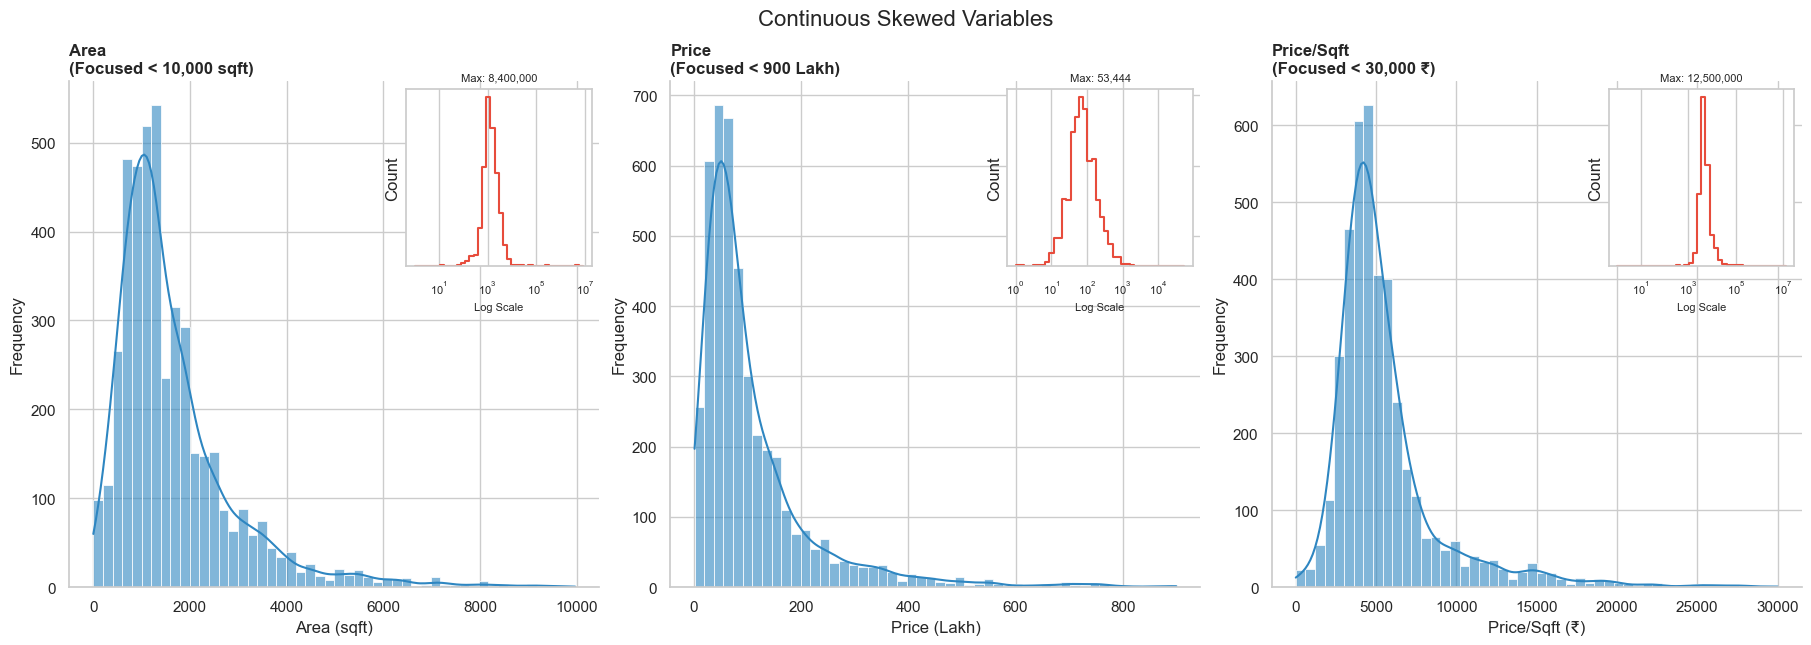

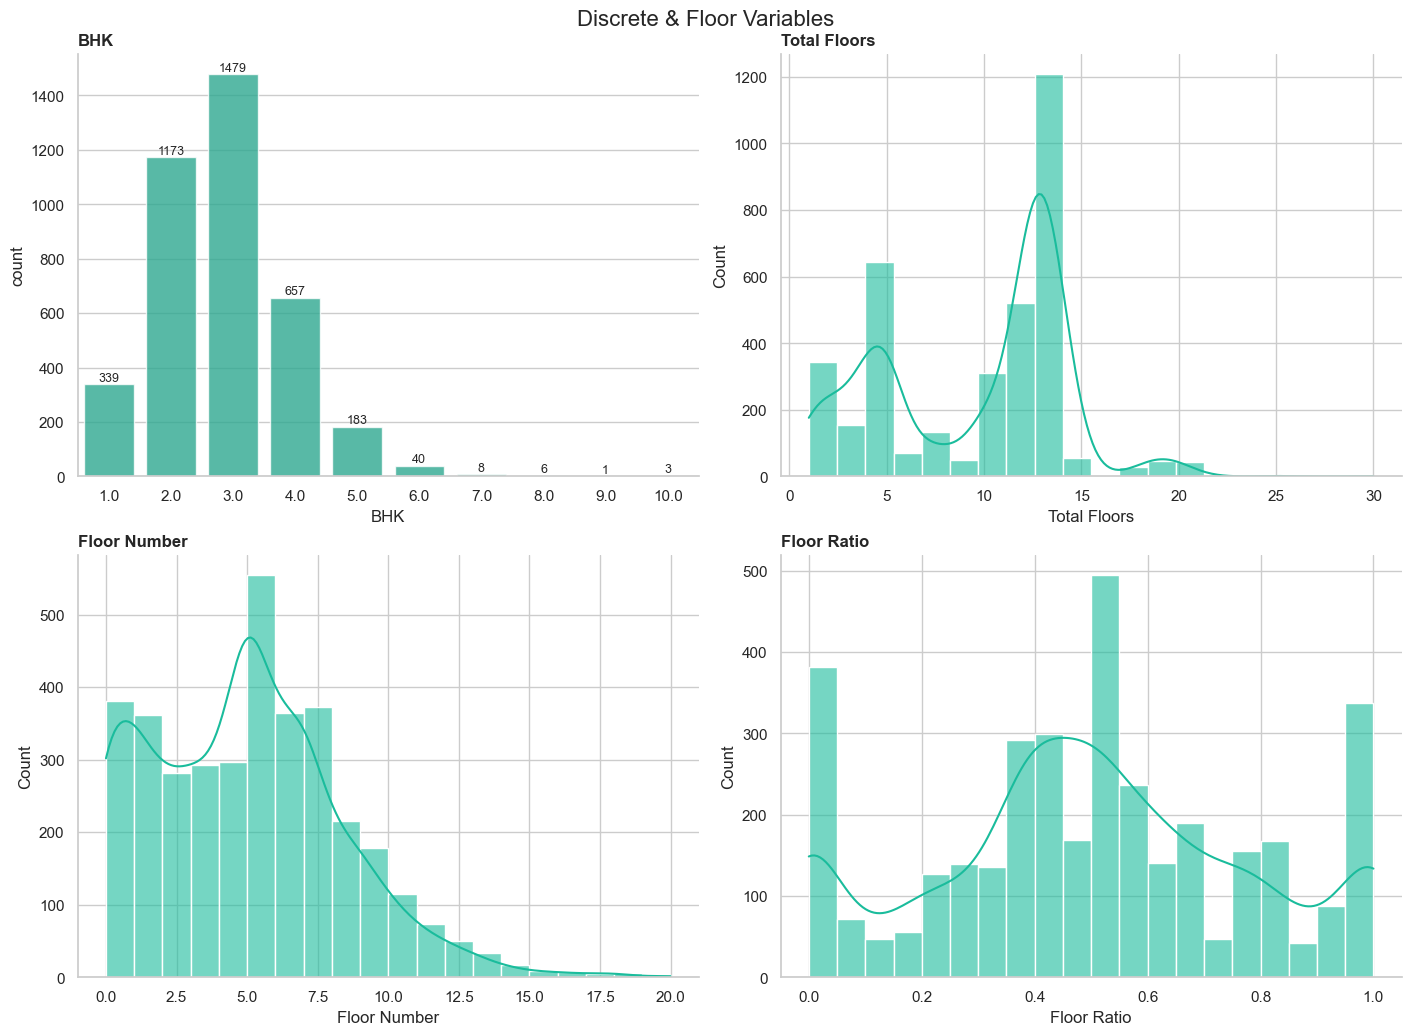

In [12]:
def plot_skewed_group_subplot(ax, col, title, limit, unit):
    data = tmp[col].dropna()
    data_zoom = data[data <= limit]
    
    # --- MAIN PLOT (ZOOMED)'ax' ---
    sns.histplot(data_zoom, bins=50, kde=True, color="#2E86C1", alpha=0.6, ax=ax)
    
    ax.set_title(f"{title}\n(Focused < {limit:,.0f} {unit})", fontsize=12, weight='bold', loc='left')
    ax.set_xlabel(f"{title} ({unit})")
    ax.set_ylabel("Frequency")
    sns.despine(ax=ax)

    # --- INSET PLOT (LOG SCALE) ---
    ax_ins = inset_axes(ax, width="35%", height="35%", loc='upper right')
    sns.histplot(data, bins=40, color="#E74C3C", ax=ax_ins, log_scale=True, element="step", fill=False)
    
    ax_ins.set_title(f"Max: {data.max():,.0f}", fontsize=8)
    ax_ins.set_xlabel("Log Scale", fontsize=8)
    ax_ins.set_yticks([]) 
    ax_ins.tick_params(axis='x', labelsize=8)

def plot_discrete_group_subplot(ax, col, title, color="#1ABC9C"):
    data = tmp[col].dropna()
    
    if data.nunique() <= 15:
        sns.countplot(x=data, ax=ax, color=color, alpha=0.8)
        ax.bar_label(ax.containers[0], fontsize=9)
    else:
        sns.histplot(data, bins=20, kde=True, ax=ax, color=color, alpha=0.6)

    ax.set_title(f"{title}", fontsize=12, weight='bold', loc='left')
    ax.set_xlabel(title)
    sns.despine(ax=ax)

group1_configs = [
    ('area_sqft', 'Area', 10000, 'sqft'),
    ('price_lakh', 'Price', 900, 'Lakh'),
    ('ppsqft', 'Price/Sqft', 30000, '₹')
]

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(18, 6), constrained_layout=True)
fig.suptitle('Continuous Skewed Variables', fontsize=16, y=1.05)
for ax, (col, title, limit, unit) in zip(axes, group1_configs):
    plot_skewed_group_subplot(ax, col, title, limit, unit)
plt.show()

group2_cols = [
    ('bhk', 'BHK'),
    ('total_floors', 'Total Floors'),
    ('floor_num', 'Floor Number'),
    ('floor_ratio', 'Floor Ratio')
]

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(14, 10), constrained_layout=True)
fig.suptitle('Discrete & Floor Variables', fontsize=16, y=1.02)
for ax, (col, title) in zip(axes.flatten(), group2_cols):
    plot_discrete_group_subplot(ax, col, title)
plt.show()

## 2.3 Range & Outliers:

In [13]:
def iqr_outlier_report(df_tmp, col):
    x = df_tmp[col].dropna()
    if x.empty:
        return {"column": col, "iqr_low": np.nan, "iqr_high": np.nan, "outlier_count": 0, "outlier_pct": np.nan}

    q1, q3 = x.quantile(0.25), x.quantile(0.75)
    iqr = q3 - q1
    lo, hi = q1 - 1.5*iqr, q3 + 1.5*iqr
    out = ((x < lo) | (x > hi)).sum()
    return {
        "column": col,
        "iqr_low": lo,
        "iqr_high": hi,
        "outlier_count": int(out),
        "outlier_pct": round(out / len(x) * 100, 2)
    }

iqr_df = pd.DataFrame([iqr_outlier_report(tmp, c) for c in num_cols])
iqr_df

,column,iqr_low,iqr_high,outlier_count,outlier_pct
0,area_sqft,-900.000000,3780.000000,315,6.97
1,ppsqft,-224.000000,10152.000000,394,9.48
2,price_lakh,-91.562500,267.737500,367,8.43
3,bhk,0.500000,4.500000,241,6.20
4,floor_num,-5.500000,14.500000,30,0.83
5,total_floors,-7.000000,25.000000,1,0.03
6,floor_ratio,-0.205128,1.230769,0,0.00


In [14]:
def get_iqr_outliers(df_tmp, col, n=10, keep="both"):
    """
    keep: 'high' / 'low' / 'both'
    """
    x = df_tmp[col].dropna()
    if x.empty:
        return pd.DataFrame()

    q1, q3 = x.quantile(0.25), x.quantile(0.75)
    iqr = q3 - q1
    lo, hi = q1 - 1.5*iqr, q3 + 1.5*iqr

    out = df_tmp[df_tmp[col].notna() & ((df_tmp[col] < lo) | (df_tmp[col] > hi))].copy()

    if keep == "high":
        out = out[out[col] > hi].sort_values(col, ascending=False).head(n)
    elif keep == "low":
        out = out[out[col] < lo].sort_values(col, ascending=True).head(n)
    else:
        top_high = out[out[col] > hi].sort_values(col, ascending=False).head(n//2)
        top_low  = out[out[col] < lo].sort_values(col, ascending=True).head(n//2)
        out = pd.concat([top_low, top_high]).sort_values(col)

    return out, lo, hi

In [15]:
key_cols_to_show = ["property_name", "square_feet", "price_per_sqft", "price", "floor"]

for c in ["area_sqft", "price_lakh", "ppsqft", "floor_num"]:
    out_df, lo, hi = get_iqr_outliers(tmp, c, n=10, keep="both")
    print(f"\n=== {c} | IQR bounds: [{lo:.2f}, {hi:.2f}] | showing sample outliers ===")
    display(out_df[key_cols_to_show + [c]])


=== area_sqft | IQR bounds: [-900.00, 3780.00] | showing sample outliers ===


,property_name,square_feet,price_per_sqft,price,floor,area_sqft
1092,"2 BHK Apartment for Sale in Anand flats, Anand...","395,009 sqft",NaN,Call for Price,Resale,3.950090e+05
920,2 BHK House for Sale in Majura Gate Surat,90 acre,₹1 per sqft,₹50 Lac,Resale,3.920400e+06
2040,2 BHK House for Sale in Majura Gate Surat,90 acre,₹1 per sqft,₹50 Lac,Resale,3.920400e+06
3826,2 BHK House for Sale in Adajan Surat,"390,045 sqm",₹349 per sqft,₹146.33 Cr,1 out of 1,4.198405e+06
1040,Plot/Land for Sale in Kim Surat,8400000 sqft,NaN,Call for Price,NaN,8.400000e+06



=== price_lakh | IQR bounds: [-91.56, 267.74] | showing sample outliers ===


,property_name,square_feet,price_per_sqft,price,floor,price_lakh
3702,Showroom for Sale in Piplod Surat,"27,375 sqft","₹11,507 per sqft",₹31.50 Cr,Ground out of 8,3150.0
3708,Land for Sale in Bardoli Surat,291000 sqft,"₹1,409 per sqft",₹41 Cr,NaN,4100.0
3796,Industrial Shed for Sale in Khatodra Wadi Surat,2200 sqyrd,"₹27,778 per sqft",₹55 Cr,Resale,5500.0
3826,2 BHK House for Sale in Adajan Surat,"390,045 sqm",₹349 per sqft,₹146.33 Cr,1 out of 1,14633.0
3731,1 BHK Apartment for Sale in 395004 Surat,27646 sqft,"₹9,852 per sqft",₹534.44 Cr,3 out of 7,53444.0



=== ppsqft | IQR bounds: [-224.00, 10152.00] | showing sample outliers ===


,property_name,square_feet,price_per_sqft,price,floor,ppsqft
3839,3 BHK House for Sale in tusli niketan society...,225 sqft,"₹1,66,667 per sqft",₹5 Cr,Resale,166667.0
715,2 BHK House for Sale in Dindoli Surat,18 sqft,"₹1,94,444 per sqft",₹35 Lac,Ground out of 1,194444.0
3165,2 BHK House for Sale in Meera Nagar Surat,16 sqft,"₹2,00,000 per sqft",₹1 Cr,Resale,200000.0
1986,2 BHK House for Sale in Meera Nagar Surat,16 sqft,"₹2,00,000 per sqft",₹1 Cr,Resale,200000.0
3718,Industrial Land for Sale in Kim Surat,10 sqft,"₹1,25,00,000 per sqft",₹12.50 Cr,NaN,12500000.0



=== floor_num | IQR bounds: [-5.50, 14.50] | showing sample outliers ===


,property_name,square_feet,price_per_sqft,price,floor,floor_num
3460,"3 BHK Apartment for Sale in Eco Grandeur, Alth...",1278 sqft,"₹5,252 per sqft",₹1.22 Cr,18 out of 19,18.0
3493,"3 BHK Apartment for Sale in Eco Grandeur, Alth...",2323 sqft,"₹5,209 per sqft",₹1.21 Cr,18 out of 19,18.0
3936,4 BHK Apartment for Sale in Piplod Surat,2085 sqft,"₹8,494 per sqft",₹3.22 Cr,19 out of 19,19.0
3988,5 BHK Penthouse for Sale in Pal Surat,4370 sqft,"₹6,178 per sqft",₹2.70 Cr,20 out of 20,20.0
1569,"2 BHK Apartment for Sale in Santvan Lexon, Pal...",1320 sqft,"₹4,167 per sqft",₹55 Lac,20 out of 21,20.0


- `area_sqft` (IQR high bound ≈ 3,780 sqft)
    - The largest outliers include listings with extremely large areas such as “90 acre” and multi-million sqft entries (e.g., 8,400,000 sqft), which strongly suggests the dataset contains land/plot or non-standard properties, not only typical flats.
    - However, several outlier rows show inconsistent fields (e.g., floor = "Resale"), indicating misaligned/dirty data, so some extreme values may be valid but the record quality is questionable.

- `price_lakh` (IQR high bound ≈ 268 lakh)
    - High-price outliers often correspond to commercial/land/industrial listings (e.g., Showroom, Land, Industrial Shed), which makes them plausible genuine extremes.
    - Still, some extreme cases appear suspicious (e.g., a “1 BHK Apartment” priced at ₹534.44 Cr) and likely reflect incorrect listing information or data errors.

- `ppsqft` (IQR high bound ≈ 10,152 ₹/sqft)
    - The outliers show unrealistically large price-per-sqft values (e.g., ₹166,667, ₹200,000, up to ₹12,500,000 per sqft), often paired with implausibly small areas (e.g., 10–18 sqft).
    - This pattern strongly suggests data entry/parsing issues (misformatted currency strings or invalid area values), rather than genuine market prices.

- `floor_num` (IQR high bound ≈ 14.5 floors)
    - Outliers here are mostly genuine: examples like 18–20 out of 19–21 floors are consistent with high-rise buildings and show valid “X out of Y” patterns. These outliers reflect tall buildings rather than obvious errors.

## 2.4. Data quantity

In [16]:
impossible_rules = {
    "area_sqft":      lambda s: s <= 0,
    "ppsqft":         lambda s: s <= 0,
    "price_lakh":     lambda s: s <= 0,
    "bhk":            lambda s: (s <= 0) | (s > 15),
    "floor_num":      lambda s: s < 0,
    "total_floors":   lambda s: s <= 0,
    "floor_ratio":    lambda s: (s < 0) | (s > 1),
}

impossible_summary = []
for col, rule in impossible_rules.items():
    x = tmp[col].dropna()
    cnt = int(rule(x).sum())
    impossible_summary.append({
        "column": col,
        "impossible_count": cnt,
        "impossible_pct_nonnull": round(cnt / len(x) * 100, 2) if len(x) else np.nan
    })

impossible_df = pd.DataFrame(impossible_summary).sort_values("impossible_count", ascending=False)
impossible_df

,column,impossible_count,impossible_pct_nonnull
0,area_sqft,0,0.0
1,ppsqft,0,0.0
2,price_lakh,0,0.0
3,bhk,0,0.0
4,floor_num,0,0.0
5,total_floors,0,0.0
6,floor_ratio,0,0.0


In [17]:
# floor_num should not exceed total_floors
floor_inconsistent = tmp.dropna(subset=["floor_num","total_floors"])
bad_floor = (floor_inconsistent["floor_num"] > floor_inconsistent["total_floors"]).sum()

print("Inconsistent floors (floor_num > total_floors):", int(bad_floor))

Inconsistent floors (floor_num > total_floors): 0


### Placeholder values

In [18]:
call_for_price = (df["price"].astype(str).str.strip().str.lower() == "call for price").sum()
print("Placeholder 'Call for Price' in price:", call_for_price, f"({call_for_price/len(df)*100:.2f}%)")

parse_fail = pd.DataFrame({
    "numeric_col": ["area_sqft","ppsqft","price_lakh","floor_num"],
    "raw_col":     ["square_feet","price_per_sqft","price","floor"],
})

parse_fail["raw_nonnull"] = [df[r].notna().sum() for r in parse_fail["raw_col"]]
parse_fail["parsed_nonnull"] = [tmp[n].notna().sum() for n in parse_fail["numeric_col"]]
parse_fail["parse_fail_count"] = parse_fail["raw_nonnull"] - parse_fail["parsed_nonnull"]
parse_fail["parse_fail_pct_overall"] = (parse_fail["parse_fail_count"]/len(df)*100).round(2)

parse_fail

Placeholder 'Call for Price' in price: 173 (3.82%)


,numeric_col,raw_col,raw_nonnull,parsed_nonnull,parse_fail_count,parse_fail_pct_overall
0,area_sqft,square_feet,4525,4519,6,0.13
1,ppsqft,price_per_sqft,4157,4157,0,0.00
2,price_lakh,price,4525,4352,173,3.82
3,floor_num,floor,4480,3617,863,19.07


In [19]:
placeholder_candidates = [0, -1, 999, 9999, 99999]

placeholder_hits = []
for c in num_cols:
    vc = tmp[c].value_counts(dropna=True)
    for p in placeholder_candidates:
        if p in vc.index:
            placeholder_hits.append({"column": c, "placeholder": p, "count": int(vc[p])})

placeholder_df = pd.DataFrame(placeholder_hits)
placeholder_df if not placeholder_df.empty else "No common numeric placeholder values found."

,column,placeholder,count
0,area_sqft,999,3
1,floor_num,0,381
2,floor_ratio,0,381


# 3. Categorical Columns Analysis

## 3.1 Value distribution

In [20]:
cat_cols_dict = {
    1: 'transaction',
    2: 'status',
    3: 'furnishing',
    4: 'facing',
    5: 'areaWithType'
}

In [21]:
def analyze_value_distribution(col_name):
    print(f"\n=== Value Distribution for column: {col_name} ===")
    
    value_counts = df[col_name].value_counts(dropna=False)
    print("Number of unique values:", df[col_name].nunique())
    print("Top 10 most frequent values:\n", value_counts.head(10))

    top5 = value_counts.head(5)
    
    plt.figure(figsize=(8,4))
    sns.barplot(x=top5.values, y=top5.index, hue=top5.index, dodge=False, palette="viridis", legend=False)
    plt.title(f'Top 5 Values in {col_name}')
    plt.xlabel('Count')
    plt.ylabel(col_name)
    plt.show()

1. `transaction`
- **Number of unique values:** 38  
- **Top values:** `Resale` (2197), `New Property` (1486), `Unfurnished` (404).  
- **Observations:**  
  - Only a few values (`Resale`, `New Property`) are meaningful.  
  - Irrelevant entries such as `2`, `3`, `No`, `Congo` suggest data entry errors or mislabeling.  
  - Missing values: 104  

2. `status`
- **Number of unique values:** 138 
- **Top values:** `Ready to Move` (3078), `Poss. by Dec '24` (155), `Poss. by Dec '25` (102), …  
- **Observations:**  
  - Inconsistent formats for possession dates (`Poss. by Dec '24` vs `Poss by Dec 24`).  
  - Some entries like `Resale` appear here which should belong to `transaction`.  

3. `furnishing`
- **Number of unique values:** 78   
- **Top values:** `Unfurnished` (2322), `Semi-Furnished` (491), `Furnished` (457).  
- **Observations:**  
  - Erroneous entries such as `East`, `1`, `2`, `3`, `1 Covered` likely come from misaligned rows or parsing errors.  
  - Missing values: 340.  

4. `facing`
- **Number of unique values:** 176 → extremely inconsistent.  
- **Top values:** `East` (1487), `NaN` (589), `South -West` (354), `2` (329), `1` (255), …  
- **Observations:**  
  - Numeric entries (`1`, `2`, `3`) and descriptive entries like `Main Road`, `Garden/Park` are mixed, representing inconsistent data.  
  - Missing values: 589.  

5. `areaWithType`
- **Number of unique values:** 6 
- **Top values:** `Super Area` (2599), `Carpet Area` (1671), `Plot Area` (214), `Built Area` (35), `Status` (4), `Transaction` (2)  
- **Observations:**  
  - Invalid entries (`Status`, `Transaction`) suggest misaligned data.  
  - Most data concentrated in top 2–3 categories.  


=== Value Distribution for column: transaction ===
Number of unique values: 38
Top 10 most frequent values:
 transaction
Resale            2197
New Property      1486
Unfurnished        404
NaN                104
Semi-Furnished      91
Furnished           69
2                   24
3                   22
No                  20
Congo               19
Name: count, dtype: int64


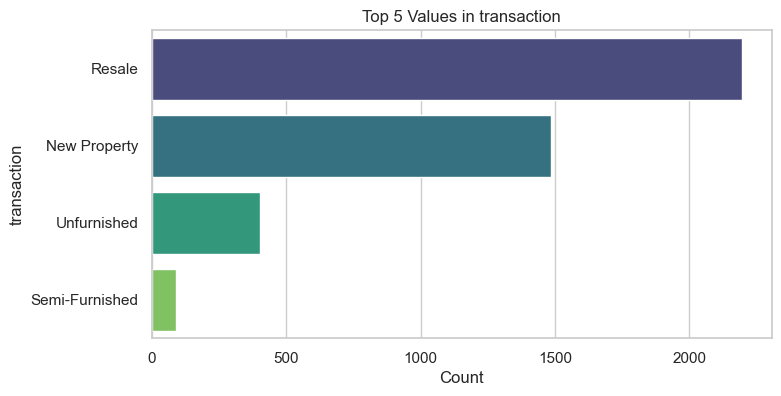


=== Value Distribution for column: status ===
Number of unique values: 138
Top 10 most frequent values:
 status
Ready to Move       3078
Poss. by Dec '24     155
Poss. by Dec '25     102
Resale                95
Poss. by Jul '24      78
Poss. by Apr '25      72
Freehold              70
Poss. by Mar '25      59
Poss. by Jan '25      55
Poss. by Aug '24      54
Name: count, dtype: int64


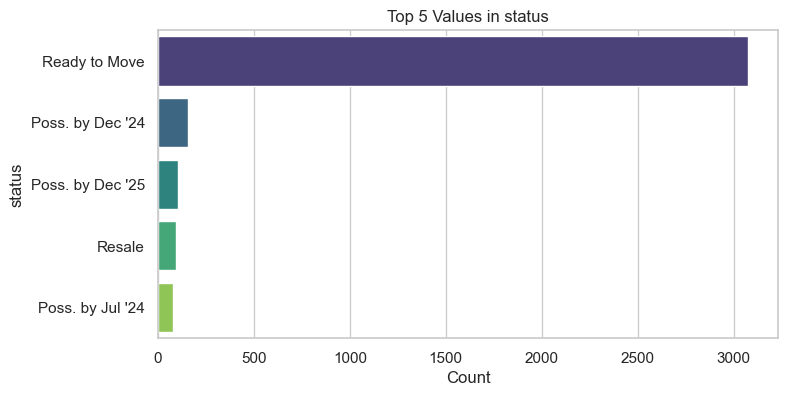


=== Value Distribution for column: furnishing ===
Number of unique values: 78
Top 10 most frequent values:
 furnishing
Unfurnished       2322
Semi-Furnished     491
Furnished          457
NaN                340
East               248
1                  134
2                  120
3                   83
1 Covered           28
4                   20
Name: count, dtype: int64


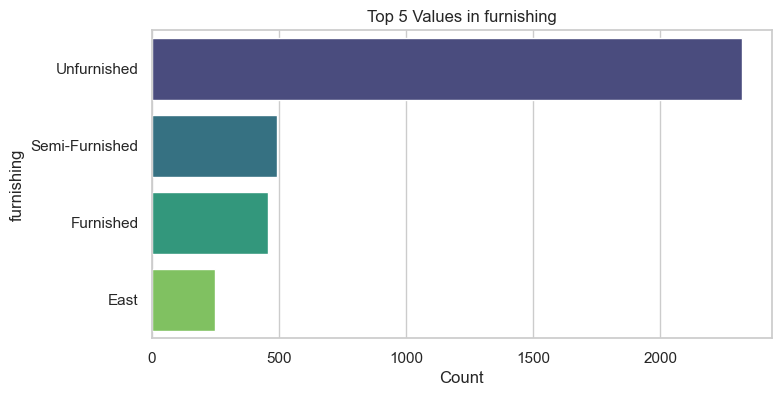


=== Value Distribution for column: facing ===
Number of unique values: 176
Top 10 most frequent values:
 facing
East                      1487
NaN                        589
South -West                354
2                          329
1                          255
North - East               235
Main Road                  184
3                          162
Garden/Park, Main Road     124
North                       97
Name: count, dtype: int64


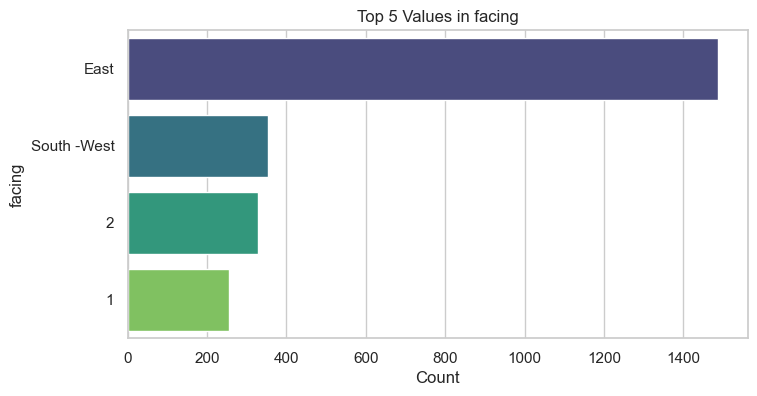


=== Value Distribution for column: areaWithType ===
Number of unique values: 6
Top 10 most frequent values:
 areaWithType
Super Area     2599
Carpet Area    1671
Plot Area       214
Built Area       35
Status            4
Transaction       2
Name: count, dtype: int64


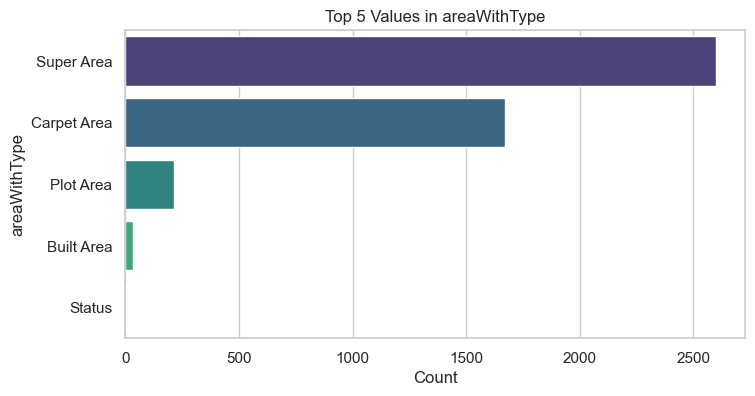

In [22]:
for i, col in cat_cols_dict.items():
    analyze_value_distribution(col)

## 3.2 Data Quality

We first analyze the percentage of missing values in every categorical columns
- `transaction`: 2.3% missing percentage
- `status`: 0.02% missing percentage
- `furnishing`: 7.51% missing percentage
- `facing`: 13.02% missing percentage
- `areaWithType`: 0% missing percentage

In [23]:
def missing_percentage(col_name):
    total = len(df)
    missing_count = df[col_name].isna().sum()
    missing_pct = missing_count / total * 100
    return missing_count, missing_pct

In [24]:
category_missing_summary = []

for i, col in cat_cols_dict.items():
    count, pct = missing_percentage(col)
    category_missing_summary.append([col, count, pct])

category_missing_df = pd.DataFrame(category_missing_summary, columns=['Column', 'Missing Count', 'Missing %'])
category_missing_df = category_missing_df.sort_values(by='Missing %', ascending=False)
category_missing_df

,Column,Missing Count,Missing %
3,facing,589,13.016575
2,furnishing,340,7.513812
0,transaction,104,2.298343
1,status,1,0.022099
4,areaWithType,0,0.000000


In [25]:
def analyze_category_inconsistencies(col_name):
    print(f"=== Category Analysis for column: {col_name} ===")
    
    # Drop missing values
    values = df[col_name].dropna().astype(str).str.strip()
    
    # Unique values
    unique_vals = values.unique()
    print(f"Number of unique values: {len(unique_vals)}")
    
    # Detect unexpected / abnormal values
    # We consider numeric-only entries or entries with unusual symbols as abnormal
    abnormal_vals = [v for v in unique_vals if not v.replace(' ', '').isalpha()]
    if abnormal_vals:
        print("Unexpected / abnormal values detected:", abnormal_vals[:10])
    else:
        print("No obvious abnormal values detected")
    print("\n")

- `transaction`: data entry errors, misaligned rows, or mixed information
- `status`: many variations indicate typos and mixed formats, and some numeric entries appear
- `furnishing`: misalignment of data or incorrect entry, as furnishing should only include `Unfurnished`, `Semi-Furnished`, or `Furnished`
- `facing`: mixed numeric entries and descriptive text indicate data inconsistencies.
- `areaWithType`: Main categories (`Super Area`, `Carpet Area`, `Plot Area`, `Built Area`) are consistent

In [26]:
for i, col in cat_cols_dict.items():
    analyze_category_inconsistencies(col)

=== Category Analysis for column: transaction ===
Number of unique values: 38
Unexpected / abnormal values detected: ['Semi-Furnished', 'Main Road, Garden/Park', '1', '3', '4', '3 Covered', '2', '10 m', '1 Covered', 'Garden/Park']


=== Category Analysis for column: status ===
Number of unique values: 138
Unexpected / abnormal values detected: ["Poss. by Oct '24", "Poss. by Jan '26", "Poss. by Dec '25", "Poss. by Jun '24", "Poss. by Sep '25", "Poss. by Feb '26", '1 out of 7', "Poss. by Jul '24", "Poss. by Dec '26", "Poss. by Apr '25"]


=== Category Analysis for column: furnishing ===
Number of unique values: 78
Unexpected / abnormal values detected: ['Semi-Furnished', '2', '1', '3', '1 Covered,', '2 Covered', '1 Covered', '26 Covered', '1 Open', '6']


=== Category Analysis for column: facing ===
Number of unique values: 176
Unexpected / abnormal values detected: ['South -West', '2', 'North - East', 'South - East', '1', 'Garden/Park', '3', 'North - West', '6', 'Co-operative Society']


- `transaction`: 
    - Keep only valid categories (`Resale`, `New Property`).  
    - Map all other values to `Other` or clean manually.

- `status`:
    - Standardize possession dates to a uniform format.  
    - Remove or correct numeric/misaligned entries.  
    - Group similar statuses if appropriate.

- `furnishing`:
    - Map valid entries to `Unfurnished`, `Semi-Furnished`, or `Furnished`.  
    - Map rare or incorrect entries to `Other` or `NaN`.

- `facing`: 
    - Normalize directions (`East`, `West`, `North`, `South`, `North-East`, `South-West`, etc.).  
    - Map unrelated or rare entries to `Other` or missing.

- `areaWithType`:
    - Retain current valid categories (`Super Area`, `Carpet Area`, `Plot Area`, `Built Area`).  
    - Remove any minor invalid entries if present.

# 4. Missing Data Analysis

We now break down the missing data percentage of every columns in the data

In [27]:
missing_summary = []

for col in df.columns:
    count, pct = missing_percentage(col)
    missing_summary.append([col, count, pct])

missing_df = pd.DataFrame(missing_summary, columns=['Column', 'Missing Count', 'Missing %'])
missing_df = missing_df.sort_values(by='Missing %', ascending=False)
missing_df

,Column,Missing Count,Missing %
8,description,1371,30.298343
7,facing,589,13.016575
9,price_per_sqft,368,8.132597
6,furnishing,340,7.513812
3,transaction,104,2.298343
5,floor,45,0.994475
4,status,1,0.022099
2,square_feet,0,0.000000
1,areaWithType,0,0.000000
0,property_name,0,0.000000


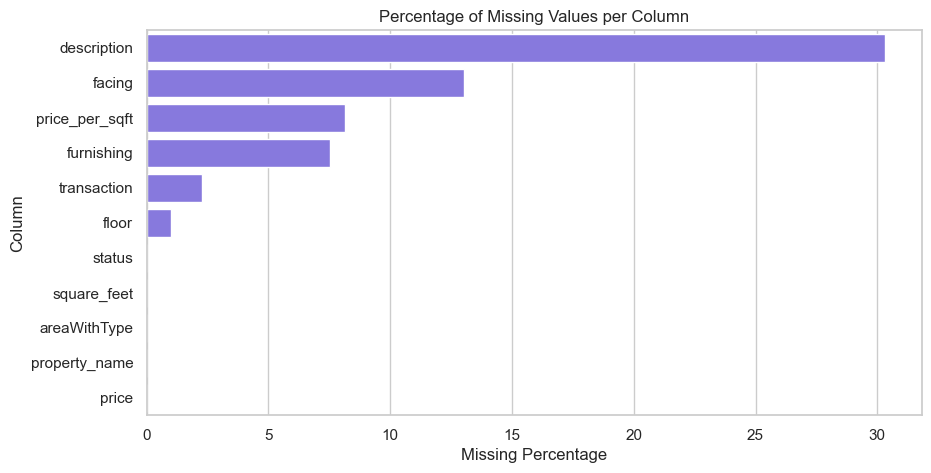

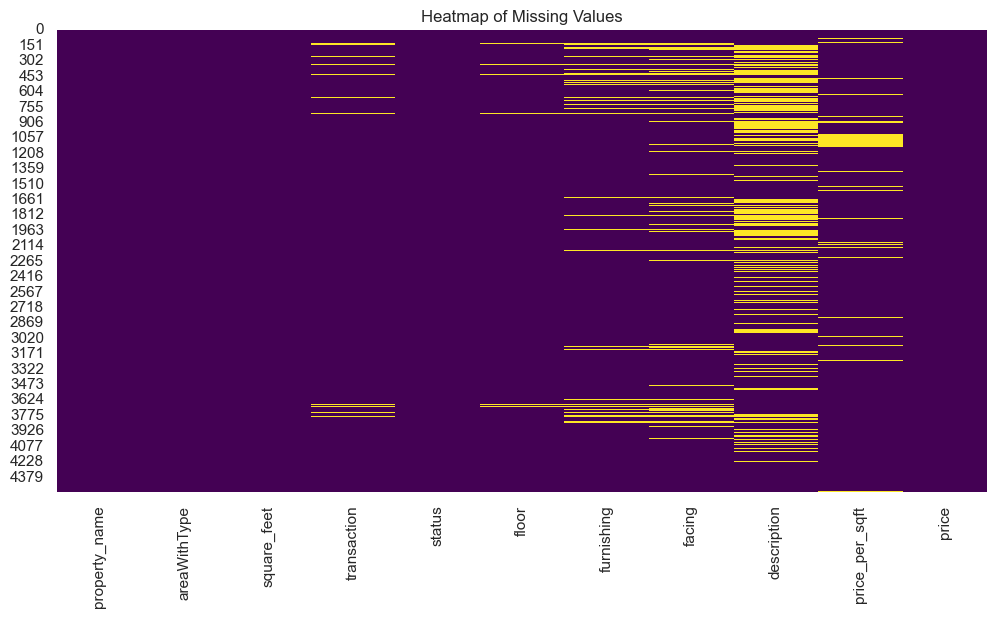

In [28]:
plt.figure(figsize=(10,5))
sns.barplot(x='Missing %', y='Column', data=missing_df, color="mediumslateblue")
plt.title('Percentage of Missing Values per Column')
plt.xlabel('Missing Percentage')
plt.ylabel('Column')
plt.show()

plt.figure(figsize=(12,6))
sns.heatmap(df.isna(), cbar=False, cmap='viridis')
plt.title('Heatmap of Missing Values')
plt.show()

- **No missing values:** The most important columns—`price`, `square_feet`, and `property_name`—are fully populated (purple). You can trust this data for modeling.
- **High Missingness:** The `facing` and `description` columns have many missing values (yellow lines). We drop them or fill them with "Unknown."
- **Patterns:** `transaction`, `floor`, and `furnishing` tend to be missing in the same rows.
- **Easy Fix:** The `price_per_sqft` column is missing a chunk at the end. Since you have both `price` and `square_feet`, you can simply calculate these values yourself

# 5. Relationships & Correlations

## 5.1 Numerical Columns

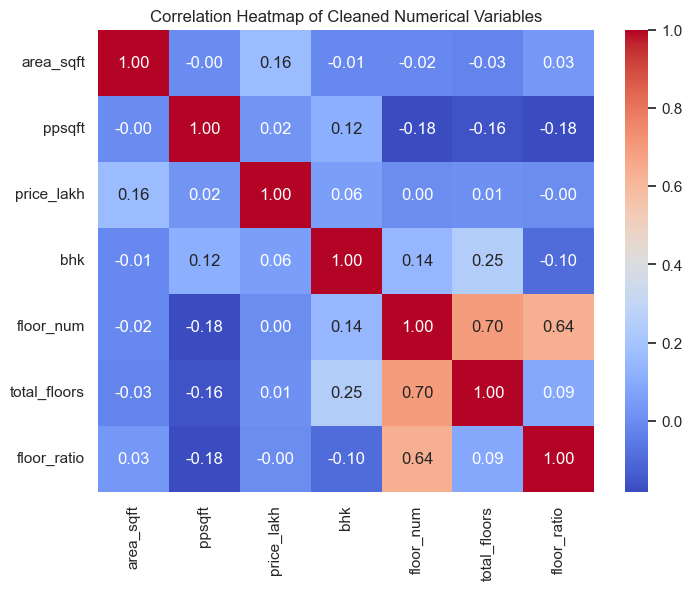

In [29]:
num_cols = ["area_sqft","ppsqft","price_lakh","bhk","floor_num","total_floors","floor_ratio"]
corr_matrix = tmp[num_cols].corr()

plt.figure(figsize=(8,6))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Correlation Heatmap of Cleaned Numerical Variables")
plt.show()

- **Strongest Relationship:** There is a high positive correlation (0.7) between `floor_num` and `total_floors`. This is logical: taller buildings (high `total_floors`) allow for higher apartment units (`floor_num`).
- **Unexpected Weakness:** The correlation between `area_sqft` and `price_lakh` is surprisingly low (**0.16**). Usually, larger area equals higher price. This suggests there may still be **outliers** or data errors in the area column.
- **Independent Variables:** Most other variables (blue squares) show very little correlation with each other, meaning they provide independent information.

## 5.2 Categorical x Categorical Cross-tabulation

The vast majority of properties are ``Unfurnished`` and face ``East`` (1,188 listings). This category dominates the entire dataset which is highly imbalanced

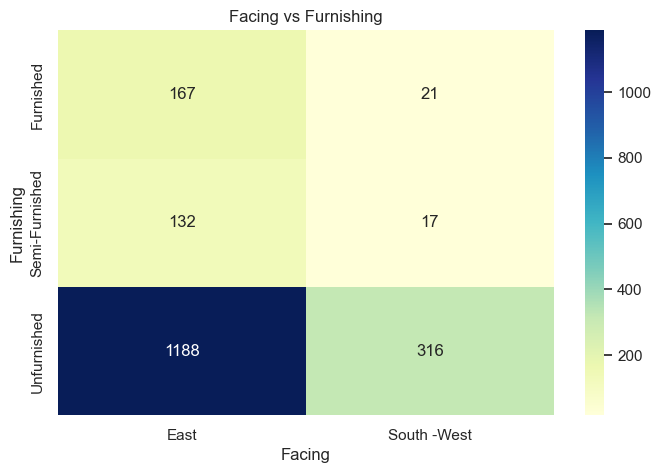

In [30]:
top_facing = df['facing'].value_counts().nlargest(2).index
top_furnishing = df['furnishing'].value_counts().nlargest(3).index

cross_tab_01 = pd.crosstab(
    df[df['facing'].isin(top_facing) & df['furnishing'].isin(top_furnishing)]['furnishing'],
    df[df['facing'].isin(top_facing) & df['furnishing'].isin(top_furnishing)]['facing']
)

plt.figure(figsize=(8,5))
sns.heatmap(cross_tab_01, annot=True, fmt="d", cmap="YlGnBu")
plt.title("Facing vs Furnishing")
plt.ylabel("Furnishing")
plt.xlabel("Facing")
plt.show()

There is a very strong trend here. ``New Properties`` are almost exclusively ``Unfurnished`` (1,353 listings). It is extremely rare to find a ``Furnished`` or ``Semi-Furnished`` new property

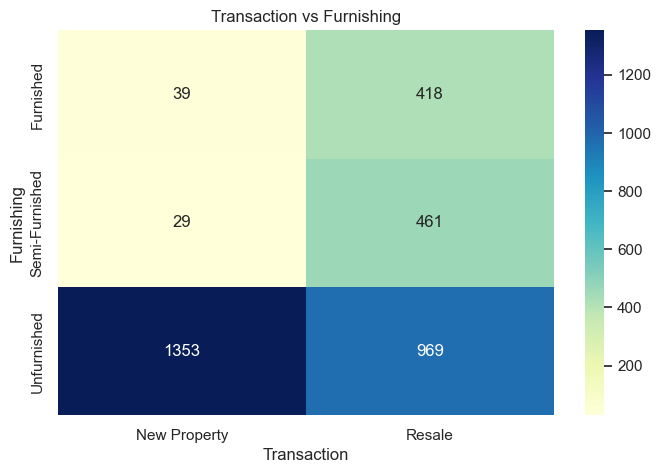

In [31]:
top_trans = df['transaction'].value_counts().nlargest(2).index
top_furnishing = df['furnishing'].value_counts().nlargest(3).index

cross_tab_02 = pd.crosstab(
    df[df['transaction'].isin(top_trans) & df['furnishing'].isin(top_furnishing)]['furnishing'],
    df[df['transaction'].isin(top_trans) & df['furnishing'].isin(top_furnishing)]['transaction']
)

plt.figure(figsize=(8,5))
sns.heatmap(cross_tab_02, annot=True, fmt="d", cmap="YlGnBu")
plt.title("Transaction vs Furnishing")
plt.ylabel("Furnishing")
plt.xlabel("Transaction")
plt.show()

``Super Area`` is the most popular measurement for both ``New Properties`` (1023) and ``Resale`` (1266). It clearly dominates the market

``Plot Area`` is virtually non-existent (only 55 listings total). This category is insignificant and could likely be dropped or ignored.

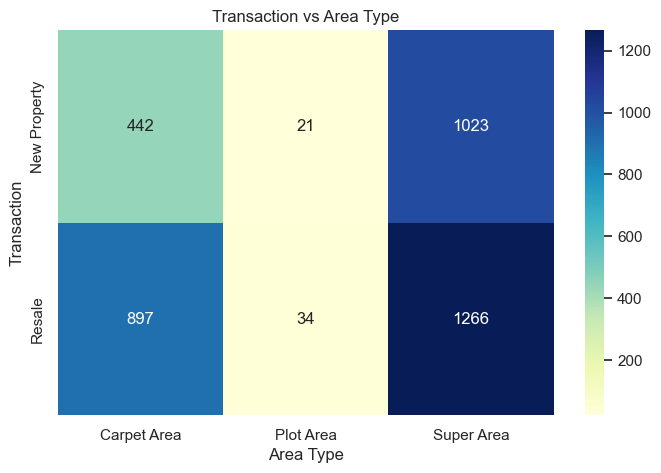

In [32]:
top_trans = df['transaction'].value_counts().nlargest(2).index
top_area = df['areaWithType'].value_counts().nlargest(3).index

cross_tab_03 = pd.crosstab(
    df[df['transaction'].isin(top_trans) & df['areaWithType'].isin(top_area)]['transaction'],
    df[df['transaction'].isin(top_trans) & df['areaWithType'].isin(top_area)]['areaWithType']
)

plt.figure(figsize=(8,5))
sns.heatmap(cross_tab_03, annot=True, fmt="d", cmap="YlGnBu")
plt.title("Transaction vs Area Type")
plt.ylabel("Transaction")
plt.xlabel("Area Type")
plt.show()

# 6. Initial Observations & Insights